In [1]:
#importing dependencies

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import _pickle as cpickle #to store model histories in a file
import os
import imageio
from PIL import Image

use_cuda = False
device   = torch.device('cpu')
if torch.cuda.is_available():
    use_cuda = True
    device   = torch.device('cuda')
print(use_cuda)    
    
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots"

True


In [2]:
#specifying parameters
image_size = 64
G_input_dim = 100
G_output_dim = 3
D_input_dim = 3
D_output_dim = 1
num_filters = [1024, 512, 256, 128]

learning_rate_G = 0.0005
betas_G = (0.9, 0.999)
learning_rate_D = 0.0001
betas_D = (0.5, 0.999)
batch_size = 512
num_epochs = 50

data_dir = './Train_data'
save_dir = './DCGAN_results/'

In [3]:
print(os.getcwd())

/home/shreyashpandey/PoseGuided


In [4]:
#loading data

transform = transforms.Compose([#transforms.Scale(image_size),
                                transforms.ToTensor()])
                                #transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                 #                    std=(0.5, 0.5, 0.5))])

df_data = dsets.ImageFolder(data_dir, transform = transform)

data_loader = torch.utils.data.DataLoader(dataset=df_data,
                                          batch_size=batch_size,
                                          shuffle=True)


## Helper Functions

In [5]:
# De-normalization
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [6]:
# Plot losses
def plot_loss(d_losses, g_losses, num_epoch, save=False, save_dir='./DCGAN_results/', show=False):
    fig, ax = plt.subplots()
    ax.set_xlim(0, num_epochs)
    ax.set_ylim(0, max(np.max(g_losses), np.max(d_losses))*1.1)
    plt.xlabel('Epoch {0}'.format(num_epoch + 1))
    plt.ylabel('Loss values')
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'DCGAN_losses_epoch_{:d}'.format(num_epoch + 1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()


def plot_result(generator, noise, num_epoch, save=False, save_dir='./DCGAN_results/', show=False, fig_size=(5, 5)):
    generator.eval()

    gen_image = generator(noise)
    gen_image = denorm(gen_image)

    generator.train()

    n_rows = np.sqrt(noise.size()[0]).astype(np.int32)
    n_cols = np.sqrt(noise.size()[0]).astype(np.int32)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
    for ax, img in zip(axes.flatten(), gen_image):
        ax.axis('off')
        ax.set_adjustable('box-forced')
        # Scale to 0-255
        img = (((img - img.min()) * 255) / (img.max() - img.min())).cpu().data.numpy().transpose(1, 2, 0).astype(np.uint8)
        # ax.imshow(img.cpu().data.view(image_size, image_size, 3).numpy(), cmap=None, aspect='equal')
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    title = 'Epoch {0}'.format(num_epoch+1)
    fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'DCGAN_epoch_{:d}'.format(num_epoch+1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

## Generator Model

In [7]:
class Generator(nn.Module):
    def __init__(self, input_dim, num_filters, output_dim):
        super(Generator, self).__init__()

        # Hidden layers
        self.hidden_layer = nn.Sequential()
        for i in range(len(num_filters)):
            # Deconvolutional layer
            if i == 0:
                deconv = nn.ConvTranspose2d(input_dim, num_filters[i], kernel_size=4, stride=1, padding=0)
            else:
                deconv = nn.ConvTranspose2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

            deconv_name = 'deconv' + str(i + 1)
            self.hidden_layer.add_module(deconv_name, deconv)

            # Initializer
            nn.init.normal_(deconv.weight, mean=0.0, std=0.02)
            nn.init.constant_(deconv.bias, 0.0)

            # Batch normalization
            bn_name = 'bn' + str(i + 1)
            self.hidden_layer.add_module(bn_name, nn.BatchNorm2d(num_filters[i]))

            # Activation
            act_name = 'act' + str(i + 1)
            self.hidden_layer.add_module(act_name, nn.ReLU())

        # Output layer
        self.output_layer = nn.Sequential()
        # Deconvolutional layer
        out = nn.ConvTranspose2d(num_filters[i], output_dim, kernel_size=4, stride=2, padding=1)
        self.output_layer.add_module('out', out)
        # Initializer
        nn.init.normal_(out.weight, mean=0.0, std=0.02)
        nn.init.constant_(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('act', nn.Tanh())

    def forward(self, x):
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out


## Discriminator Model

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_filters, output_dim):
        super(Discriminator, self).__init__()

        # Hidden layers
        self.hidden_layer = nn.Sequential()
        for i in range(len(num_filters)):
            # Convolutional layer
            if i == 0:
                conv = nn.Conv2d(input_dim, num_filters[i], kernel_size=4, stride=2, padding=1)
            else:
                conv = nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)
            
            conv_name = 'conv' + str(i + 1)
            self.hidden_layer.add_module(conv_name, conv)

            # Initializer
            nn.init.normal_(conv.weight, mean=0.0, std=0.02)
            nn.init.constant_(conv.bias, 0.0)

            # Batch normalization
            if i != 0:
                bn_name = 'bn' + str(i + 1)
                self.hidden_layer.add_module(bn_name, nn.BatchNorm2d(num_filters[i]))

            # Activation
            act_name = 'act' + str(i + 1)
            self.hidden_layer.add_module(act_name, nn.LeakyReLU(0.2))

        # Output layer
        self.output_layer = nn.Sequential()
        # Convolutional layer
        out = nn.Conv2d(num_filters[i], output_dim, kernel_size=4, stride=1, padding=0)
        self.output_layer.add_module('out', out)
        # Initializer
        nn.init.normal_(out.weight, mean=0.0, std=0.02)
        nn.init.constant_(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('act', nn.Sigmoid())

    def forward(self, x):
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out

## Training

/home/shreyashpandey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/shreyashpandey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:85: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/shreyashpandey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/50], Step [1/63], D_loss: 1.3973, G_loss: 2.6604
Epoch [1/50], Step [2/63], D_loss: 6.9520, G_loss: 0.2614
Epoch [1/50], Step [3/63], D_loss: 7.2070, G_loss: 0.8732
Epoch [1/50], Step [4/63], D_loss: 7.0829, G_loss: 1.5693
Epoch [1/50], Step [5/63], D_loss: 6.0145, G_loss: 3.3379
Epoch [1/50], Step [6/63], D_loss: 4.2858, G_loss: 6.0825
Epoch [1/50], Step [7/63], D_loss: 1.4281, G_loss: 8.7624
Epoch [1/50], Step [8/63], D_loss: 0.6027, G_loss: 7.6965
Epoch [1/50], Step [9/63], D_loss: 0.9529, G_loss: 8.6686
Epoch [1/50], Step [10/63], D_loss: 0.3549, G_loss: 8.4627
Epoch [1/50], Step [11/63], D_loss: 0.5348, G_loss: 9.5181
Epoch [1/50], Step [12/63], D_loss: 0.2095, G_loss: 8.2952
Epoch [1/50], Step [13/63], D_loss: 0.4671, G_loss: 9.9218
Epoch [1/50], Step [14/63], D_loss: 0.1272, G_loss: 8.4875
Epoch [1/50], Step [15/63], D_loss: 0.4123, G_loss: 10.1267
Epoch [1/50], Step [16/63], D_loss: 0.0999, G_loss: 8.4073
Epoch [1/50], Step [17/63], D_loss: 0.2676, G_loss: 8.8398
Epoch

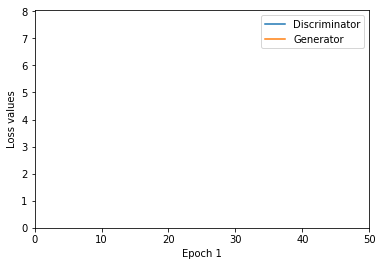

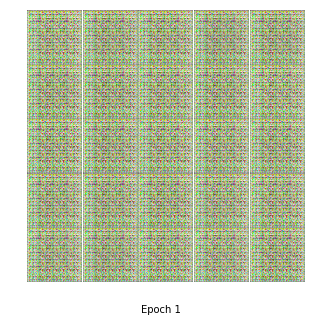

Epoch [2/50], Step [1/63], D_loss: 0.0451, G_loss: 7.0711
Epoch [2/50], Step [2/63], D_loss: 0.0464, G_loss: 7.1238
Epoch [2/50], Step [3/63], D_loss: 0.0630, G_loss: 6.8278
Epoch [2/50], Step [4/63], D_loss: 0.0493, G_loss: 7.1612
Epoch [2/50], Step [5/63], D_loss: 0.0609, G_loss: 6.8595
Epoch [2/50], Step [6/63], D_loss: 0.0495, G_loss: 6.8713
Epoch [2/50], Step [7/63], D_loss: 0.0418, G_loss: 7.0453
Epoch [2/50], Step [8/63], D_loss: 0.0421, G_loss: 7.0146
Epoch [2/50], Step [9/63], D_loss: 0.0589, G_loss: 7.0025
Epoch [2/50], Step [31/63], D_loss: 0.0716, G_loss: 5.6999
Epoch [2/50], Step [32/63], D_loss: 0.1437, G_loss: 15.8033
Epoch [2/50], Step [33/63], D_loss: 1.4266, G_loss: 0.0010
Epoch [2/50], Step [34/63], D_loss: 9.2754, G_loss: 21.8052
Epoch [2/50], Step [35/63], D_loss: 0.2050, G_loss: 25.9650
Epoch [2/50], Step [36/63], D_loss: 2.0434, G_loss: 21.8392
Epoch [2/50], Step [37/63], D_loss: 0.0159, G_loss: 18.2048
Epoch [2/50], Step [38/63], D_loss: 0.0028, G_loss: 14.7766


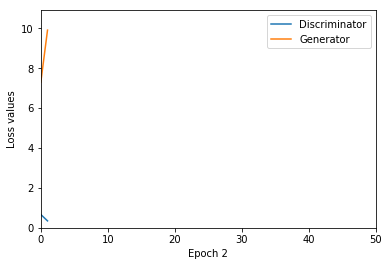

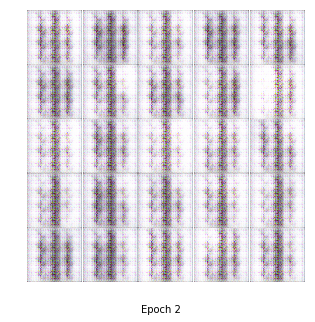

Epoch [3/50], Step [1/63], D_loss: 0.3191, G_loss: 17.4715
Epoch [3/50], Step [2/63], D_loss: 0.4537, G_loss: 12.7505
Epoch [3/50], Step [3/63], D_loss: 0.0342, G_loss: 7.5687
Epoch [3/50], Step [4/63], D_loss: 0.0456, G_loss: 4.3494
Epoch [3/50], Step [5/63], D_loss: 0.3958, G_loss: 11.5937
Epoch [3/50], Step [6/63], D_loss: 0.0883, G_loss: 12.7623
Epoch [3/50], Step [7/63], D_loss: 0.2162, G_loss: 10.5215
Epoch [3/50], Step [8/63], D_loss: 0.0755, G_loss: 7.5506
Epoch [3/50], Step [9/63], D_loss: 0.0344, G_loss: 5.0725
Epoch [3/50], Step [10/63], D_loss: 0.1264, G_loss: 5.9449
Epoch [3/50], Step [11/63], D_loss: 0.0457, G_loss: 6.0828
Epoch [3/50], Step [12/63], D_loss: 0.0475, G_loss: 5.8390
Epoch [3/50], Step [13/63], D_loss: 0.0608, G_loss: 5.1159
Epoch [3/50], Step [14/63], D_loss: 0.0768, G_loss: 5.0071
Epoch [3/50], Step [15/63], D_loss: 0.0840, G_loss: 5.0962
Epoch [3/50], Step [16/63], D_loss: 0.0943, G_loss: 4.9669
Epoch [3/50], Step [17/63], D_loss: 0.0904, G_loss: 5.1511
E

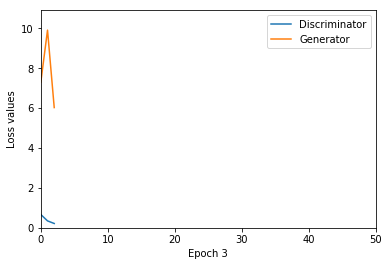

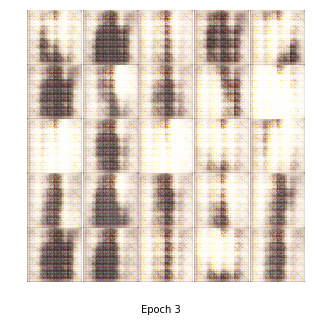

Epoch [4/50], Step [1/63], D_loss: 0.1105, G_loss: 4.4668
Epoch [4/50], Step [2/63], D_loss: 0.0886, G_loss: 4.2004
Epoch [4/50], Step [3/63], D_loss: 0.0950, G_loss: 4.4732
Epoch [4/50], Step [4/63], D_loss: 0.0809, G_loss: 4.6659
Epoch [4/50], Step [5/63], D_loss: 0.0948, G_loss: 4.3268
Epoch [4/50], Step [6/63], D_loss: 0.0900, G_loss: 4.6612
Epoch [4/50], Step [7/63], D_loss: 0.0824, G_loss: 4.8825
Epoch [4/50], Step [8/63], D_loss: 0.0756, G_loss: 4.7778
Epoch [4/50], Step [9/63], D_loss: 0.0921, G_loss: 4.7482
Epoch [4/50], Step [10/63], D_loss: 0.0822, G_loss: 5.1618
Epoch [4/50], Step [11/63], D_loss: 0.0901, G_loss: 5.0531
Epoch [4/50], Step [12/63], D_loss: 0.0644, G_loss: 4.8893
Epoch [4/50], Step [13/63], D_loss: 0.0767, G_loss: 4.9784
Epoch [4/50], Step [14/63], D_loss: 0.0729, G_loss: 5.0720
Epoch [4/50], Step [15/63], D_loss: 0.0647, G_loss: 4.9077
Epoch [4/50], Step [16/63], D_loss: 0.0617, G_loss: 5.2173
Epoch [4/50], Step [17/63], D_loss: 0.0477, G_loss: 5.2763
Epoch 

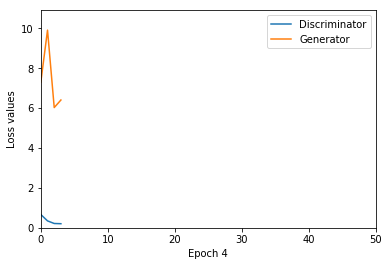

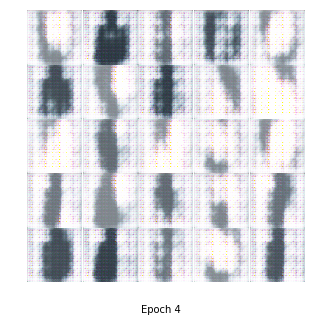

Epoch [5/50], Step [1/63], D_loss: 0.1166, G_loss: 5.4866
Epoch [5/50], Step [2/63], D_loss: 0.1197, G_loss: 3.8962
Epoch [5/50], Step [3/63], D_loss: 0.0937, G_loss: 5.3193
Epoch [5/50], Step [4/63], D_loss: 0.1160, G_loss: 4.1271
Epoch [5/50], Step [5/63], D_loss: 0.0983, G_loss: 5.7187
Epoch [5/50], Step [6/63], D_loss: 0.1199, G_loss: 4.2338
Epoch [5/50], Step [7/63], D_loss: 0.1059, G_loss: 5.4680
Epoch [5/50], Step [8/63], D_loss: 0.0897, G_loss: 4.5752
Epoch [5/50], Step [9/63], D_loss: 0.0870, G_loss: 5.4440
Epoch [5/50], Step [10/63], D_loss: 0.0725, G_loss: 5.2056
Epoch [5/50], Step [11/63], D_loss: 0.0694, G_loss: 5.1007
Epoch [5/50], Step [12/63], D_loss: 0.0618, G_loss: 5.2964
Epoch [5/50], Step [13/63], D_loss: 0.0573, G_loss: 5.4574
Epoch [5/50], Step [14/63], D_loss: 0.0489, G_loss: 5.3749
Epoch [5/50], Step [15/63], D_loss: 0.0509, G_loss: 5.1946
Epoch [5/50], Step [16/63], D_loss: 0.0438, G_loss: 5.1385
Epoch [5/50], Step [17/63], D_loss: 0.0361, G_loss: 5.3289
Epoch 

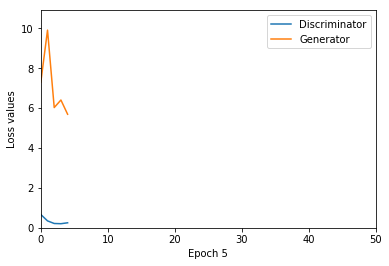

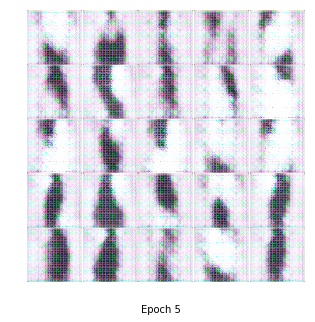

Epoch [6/50], Step [1/63], D_loss: 0.0259, G_loss: 6.3721
Epoch [6/50], Step [2/63], D_loss: 0.0218, G_loss: 5.7411
Epoch [6/50], Step [3/63], D_loss: 0.0268, G_loss: 5.7175
Epoch [6/50], Step [4/63], D_loss: 0.0414, G_loss: 5.1532
Epoch [6/50], Step [5/63], D_loss: 0.0436, G_loss: 5.1290
Epoch [6/50], Step [6/63], D_loss: 0.0378, G_loss: 5.0618
Epoch [6/50], Step [7/63], D_loss: 0.0458, G_loss: 5.0329
Epoch [6/50], Step [8/63], D_loss: 0.0561, G_loss: 5.0127
Epoch [6/50], Step [9/63], D_loss: 0.0526, G_loss: 4.8553
Epoch [6/50], Step [10/63], D_loss: 0.0665, G_loss: 4.8042
Epoch [6/50], Step [11/63], D_loss: 0.0700, G_loss: 4.7627
Epoch [6/50], Step [12/63], D_loss: 0.0554, G_loss: 4.6738
Epoch [6/50], Step [13/63], D_loss: 0.0665, G_loss: 4.6180
Epoch [6/50], Step [14/63], D_loss: 0.0783, G_loss: 4.6979
Epoch [6/50], Step [15/63], D_loss: 0.0918, G_loss: 4.7286
Epoch [6/50], Step [16/63], D_loss: 0.0761, G_loss: 4.3118
Epoch [6/50], Step [17/63], D_loss: 0.0951, G_loss: 4.4034
Epoch 

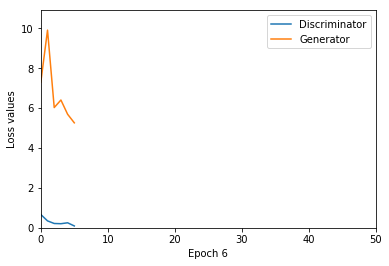

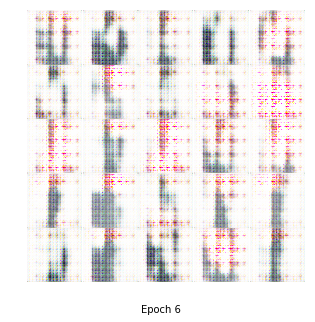

Epoch [7/50], Step [1/63], D_loss: 0.0880, G_loss: 4.7054
Epoch [7/50], Step [2/63], D_loss: 0.1002, G_loss: 4.7679
Epoch [7/50], Step [3/63], D_loss: 0.0843, G_loss: 5.4572
Epoch [7/50], Step [4/63], D_loss: 0.0734, G_loss: 4.8527
Epoch [7/50], Step [5/63], D_loss: 0.0788, G_loss: 4.8251
Epoch [7/50], Step [6/63], D_loss: 0.0838, G_loss: 5.0582
Epoch [7/50], Step [7/63], D_loss: 0.0760, G_loss: 4.9321
Epoch [7/50], Step [8/63], D_loss: 0.0896, G_loss: 4.6571
Epoch [7/50], Step [9/63], D_loss: 0.0860, G_loss: 4.8384
Epoch [7/50], Step [10/63], D_loss: 0.0728, G_loss: 4.8311
Epoch [7/50], Step [11/63], D_loss: 0.0767, G_loss: 4.8663
Epoch [7/50], Step [12/63], D_loss: 0.0656, G_loss: 4.7790
Epoch [7/50], Step [13/63], D_loss: 0.0601, G_loss: 4.7358
Epoch [7/50], Step [14/63], D_loss: 0.0546, G_loss: 5.0713
Epoch [7/50], Step [15/63], D_loss: 0.0537, G_loss: 4.9721
Epoch [7/50], Step [16/63], D_loss: 0.0460, G_loss: 4.8055
Epoch [7/50], Step [17/63], D_loss: 0.0439, G_loss: 4.8319
Epoch 

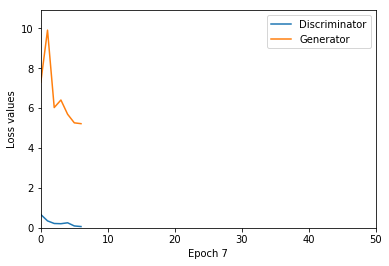

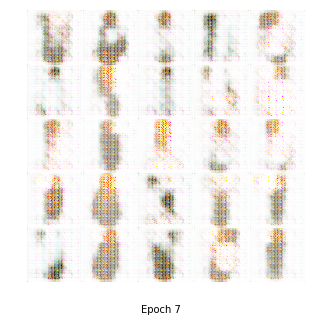

Epoch [8/50], Step [1/63], D_loss: 0.0786, G_loss: 5.0346
Epoch [8/50], Step [2/63], D_loss: 0.1072, G_loss: 7.2672
Epoch [8/50], Step [3/63], D_loss: 0.1412, G_loss: 2.6289
Epoch [8/50], Step [4/63], D_loss: 0.6665, G_loss: 21.3210
Epoch [8/50], Step [5/63], D_loss: 11.7438, G_loss: 5.9327
Epoch [8/50], Step [6/63], D_loss: 0.0171, G_loss: 0.4943
Epoch [8/50], Step [7/63], D_loss: 2.3620, G_loss: 16.5021
Epoch [8/50], Step [8/63], D_loss: 0.5032, G_loss: 18.4127
Epoch [8/50], Step [9/63], D_loss: 0.6167, G_loss: 15.5524
Epoch [8/50], Step [10/63], D_loss: 0.0107, G_loss: 12.9543
Epoch [8/50], Step [11/63], D_loss: 0.0022, G_loss: 10.6793
Epoch [8/50], Step [12/63], D_loss: 0.0020, G_loss: 8.6171
Epoch [8/50], Step [13/63], D_loss: 0.0062, G_loss: 6.7368
Epoch [8/50], Step [14/63], D_loss: 0.0314, G_loss: 5.6261
Epoch [8/50], Step [15/63], D_loss: 0.0721, G_loss: 6.0307
Epoch [8/50], Step [16/63], D_loss: 0.0406, G_loss: 6.6882
Epoch [8/50], Step [17/63], D_loss: 0.0294, G_loss: 6.3922

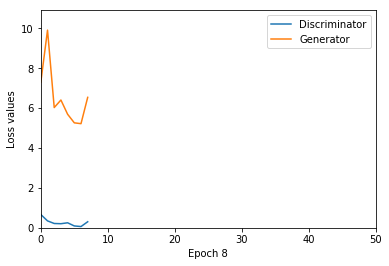

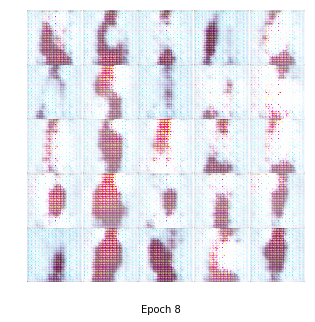

Epoch [9/50], Step [1/63], D_loss: 0.0466, G_loss: 5.7045
Epoch [9/50], Step [2/63], D_loss: 0.0602, G_loss: 5.4551
Epoch [9/50], Step [3/63], D_loss: 0.0739, G_loss: 5.7985
Epoch [9/50], Step [4/63], D_loss: 0.0753, G_loss: 5.3363
Epoch [9/50], Step [5/63], D_loss: 0.1077, G_loss: 5.9664
Epoch [9/50], Step [6/63], D_loss: 0.1183, G_loss: 5.1668
Epoch [9/50], Step [7/63], D_loss: 0.1478, G_loss: 6.8653
Epoch [9/50], Step [8/63], D_loss: 0.1653, G_loss: 3.5116
Epoch [9/50], Step [9/63], D_loss: 0.4621, G_loss: 14.3906
Epoch [9/50], Step [10/63], D_loss: 3.8649, G_loss: 0.1958
Epoch [9/50], Step [11/63], D_loss: 3.4321, G_loss: 16.0972
Epoch [9/50], Step [12/63], D_loss: 0.0559, G_loss: 20.9228
Epoch [9/50], Step [13/63], D_loss: 1.1481, G_loss: 16.9877
Epoch [9/50], Step [14/63], D_loss: 0.0038, G_loss: 13.7791
Epoch [9/50], Step [15/63], D_loss: 0.0003, G_loss: 11.7580
Epoch [9/50], Step [16/63], D_loss: 0.0010, G_loss: 9.5998
Epoch [9/50], Step [17/63], D_loss: 0.0104, G_loss: 7.4795


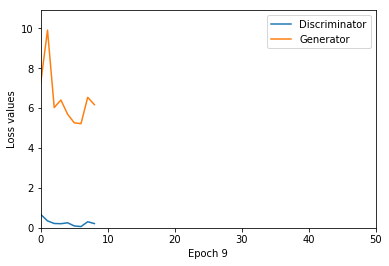

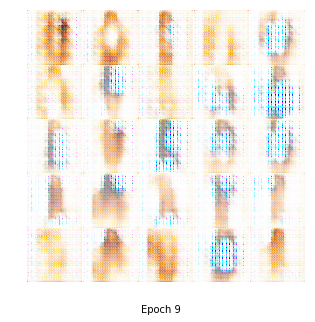

Epoch [10/50], Step [1/63], D_loss: 0.0676, G_loss: 5.3629
Epoch [10/50], Step [2/63], D_loss: 0.0584, G_loss: 5.3376
Epoch [10/50], Step [3/63], D_loss: 0.0703, G_loss: 5.2711
Epoch [10/50], Step [4/63], D_loss: 0.0727, G_loss: 5.3115
Epoch [10/50], Step [5/63], D_loss: 0.0708, G_loss: 5.2305
Epoch [10/50], Step [6/63], D_loss: 0.0607, G_loss: 5.5454
Epoch [10/50], Step [7/63], D_loss: 0.0613, G_loss: 5.1984
Epoch [10/50], Step [8/63], D_loss: 0.0785, G_loss: 5.2822
Epoch [10/50], Step [9/63], D_loss: 0.0791, G_loss: 5.2854
Epoch [10/50], Step [10/63], D_loss: 0.0727, G_loss: 5.7313
Epoch [10/50], Step [11/63], D_loss: 0.0566, G_loss: 5.6143
Epoch [10/50], Step [12/63], D_loss: 0.0681, G_loss: 5.2056
Epoch [10/50], Step [13/63], D_loss: 0.0648, G_loss: 5.4721
Epoch [10/50], Step [14/63], D_loss: 0.0572, G_loss: 5.6052
Epoch [10/50], Step [15/63], D_loss: 0.0466, G_loss: 5.5874
Epoch [10/50], Step [16/63], D_loss: 0.0496, G_loss: 5.4401
Epoch [10/50], Step [17/63], D_loss: 0.0456, G_lo

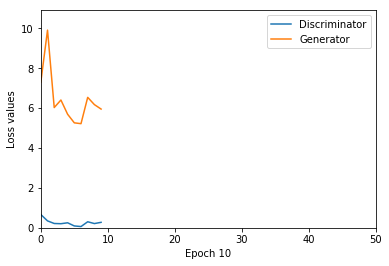

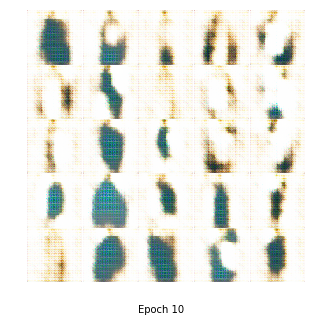

Epoch [11/50], Step [1/63], D_loss: 0.0848, G_loss: 4.5871
Epoch [11/50], Step [2/63], D_loss: 0.0774, G_loss: 4.7350
Epoch [11/50], Step [3/63], D_loss: 0.0578, G_loss: 4.6648
Epoch [11/50], Step [4/63], D_loss: 0.0706, G_loss: 4.5811
Epoch [11/50], Step [5/63], D_loss: 0.0668, G_loss: 4.7176
Epoch [11/50], Step [6/63], D_loss: 0.0534, G_loss: 4.9339
Epoch [11/50], Step [7/63], D_loss: 0.0587, G_loss: 4.8809
Epoch [11/50], Step [8/63], D_loss: 0.0470, G_loss: 5.0022
Epoch [11/50], Step [9/63], D_loss: 0.0573, G_loss: 4.8249
Epoch [11/50], Step [10/63], D_loss: 0.0598, G_loss: 5.0399
Epoch [11/50], Step [11/63], D_loss: 0.0535, G_loss: 5.1623
Epoch [11/50], Step [12/63], D_loss: 0.0571, G_loss: 5.0889
Epoch [11/50], Step [13/63], D_loss: 0.0731, G_loss: 4.6622
Epoch [11/50], Step [14/63], D_loss: 0.0656, G_loss: 5.3005
Epoch [11/50], Step [15/63], D_loss: 0.0556, G_loss: 5.6484
Epoch [11/50], Step [16/63], D_loss: 0.0580, G_loss: 5.1692
Epoch [11/50], Step [17/63], D_loss: 0.0751, G_lo

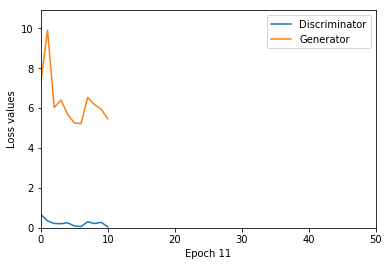

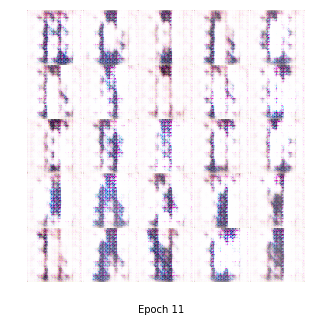

Epoch [12/50], Step [1/63], D_loss: 0.0706, G_loss: 6.1703
Epoch [12/50], Step [2/63], D_loss: 0.0477, G_loss: 6.2556
Epoch [12/50], Step [3/63], D_loss: 0.0693, G_loss: 5.7714
Epoch [12/50], Step [4/63], D_loss: 0.0736, G_loss: 5.7417
Epoch [12/50], Step [5/63], D_loss: 0.0566, G_loss: 6.3553
Epoch [12/50], Step [6/63], D_loss: 0.0693, G_loss: 5.6365
Epoch [12/50], Step [7/63], D_loss: 0.0817, G_loss: 6.7141
Epoch [12/50], Step [8/63], D_loss: 0.0732, G_loss: 4.9336
Epoch [12/50], Step [9/63], D_loss: 0.1324, G_loss: 9.4158
Epoch [12/50], Step [10/63], D_loss: 0.2450, G_loss: 2.6249
Epoch [12/50], Step [11/63], D_loss: 0.6655, G_loss: 20.3775
Epoch [12/50], Step [12/63], D_loss: 5.6653, G_loss: 3.9271
Epoch [12/50], Step [13/63], D_loss: 0.3807, G_loss: 5.4201
Epoch [12/50], Step [14/63], D_loss: 0.0543, G_loss: 7.3064
Epoch [12/50], Step [15/63], D_loss: 0.0115, G_loss: 7.5799
Epoch [12/50], Step [16/63], D_loss: 0.0123, G_loss: 7.1134
Epoch [12/50], Step [17/63], D_loss: 0.0196, G_l

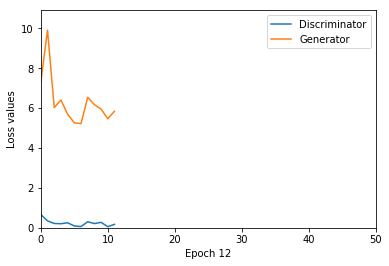

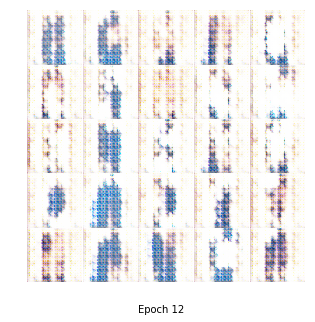

Epoch [13/50], Step [1/63], D_loss: 0.0545, G_loss: 6.0811
Epoch [13/50], Step [17/63], D_loss: 0.0323, G_loss: 6.2946
Epoch [13/50], Step [18/63], D_loss: 0.0346, G_loss: 6.3283
Epoch [13/50], Step [19/63], D_loss: 0.0375, G_loss: 6.4668
Epoch [13/50], Step [20/63], D_loss: 0.0387, G_loss: 6.7461
Epoch [13/50], Step [21/63], D_loss: 0.0430, G_loss: 6.5736
Epoch [13/50], Step [22/63], D_loss: 0.0412, G_loss: 6.5017
Epoch [13/50], Step [23/63], D_loss: 0.0602, G_loss: 6.4885
Epoch [13/50], Step [24/63], D_loss: 0.0492, G_loss: 6.9144
Epoch [13/50], Step [25/63], D_loss: 0.0574, G_loss: 7.0120
Epoch [13/50], Step [26/63], D_loss: 0.0545, G_loss: 6.7362
Epoch [13/50], Step [27/63], D_loss: 0.0682, G_loss: 6.5838
Epoch [13/50], Step [28/63], D_loss: 0.0668, G_loss: 7.1083
Epoch [13/50], Step [29/63], D_loss: 0.0571, G_loss: 6.1715
Epoch [13/50], Step [30/63], D_loss: 0.0714, G_loss: 6.7905
Epoch [13/50], Step [31/63], D_loss: 0.0544, G_loss: 6.3123
Epoch [13/50], Step [32/63], D_loss: 0.04

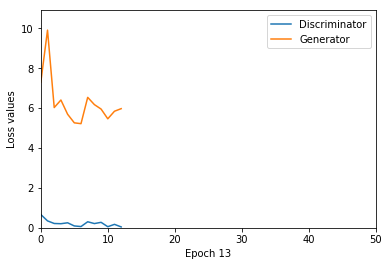

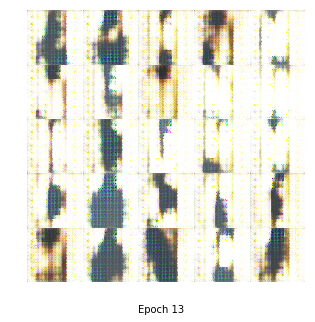

Epoch [14/50], Step [1/63], D_loss: 0.0519, G_loss: 5.6286
Epoch [14/50], Step [2/63], D_loss: 0.0490, G_loss: 5.6748
Epoch [14/50], Step [3/63], D_loss: 0.0503, G_loss: 5.3012
Epoch [14/50], Step [4/63], D_loss: 0.0614, G_loss: 5.3604
Epoch [14/50], Step [5/63], D_loss: 0.0519, G_loss: 5.4252
Epoch [14/50], Step [6/63], D_loss: 0.0454, G_loss: 5.5088
Epoch [14/50], Step [7/63], D_loss: 0.0517, G_loss: 5.3979
Epoch [14/50], Step [8/63], D_loss: 0.0549, G_loss: 5.4828
Epoch [14/50], Step [9/63], D_loss: 0.0561, G_loss: 5.6839
Epoch [14/50], Step [10/63], D_loss: 0.0432, G_loss: 5.3993
Epoch [14/50], Step [11/63], D_loss: 0.0442, G_loss: 5.6952
Epoch [14/50], Step [12/63], D_loss: 0.0432, G_loss: 5.6599
Epoch [14/50], Step [13/63], D_loss: 0.0620, G_loss: 5.0673
Epoch [14/50], Step [14/63], D_loss: 0.0551, G_loss: 6.2908
Epoch [14/50], Step [15/63], D_loss: 0.0549, G_loss: 5.0357
Epoch [14/50], Step [16/63], D_loss: 0.0439, G_loss: 5.8308
Epoch [14/50], Step [17/63], D_loss: 0.0409, G_lo

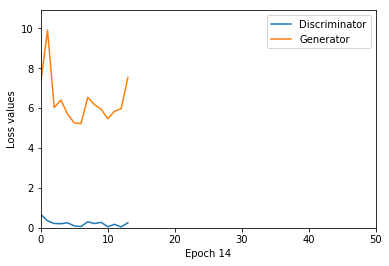

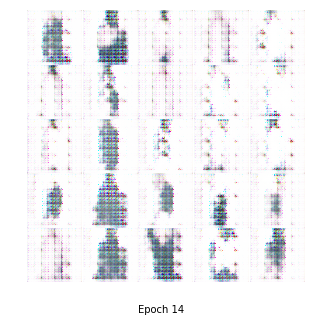

Epoch [15/50], Step [1/63], D_loss: 0.0044, G_loss: 12.2500
Epoch [15/50], Step [2/63], D_loss: 0.0098, G_loss: 9.2970
Epoch [15/50], Step [3/63], D_loss: 0.0390, G_loss: 8.1528
Epoch [15/50], Step [4/63], D_loss: 0.0546, G_loss: 7.5339
Epoch [15/50], Step [5/63], D_loss: 0.0423, G_loss: 6.8674
Epoch [15/50], Step [6/63], D_loss: 0.0528, G_loss: 6.5166
Epoch [15/50], Step [7/63], D_loss: 0.0519, G_loss: 6.1029
Epoch [15/50], Step [8/63], D_loss: 0.0561, G_loss: 5.7329
Epoch [15/50], Step [9/63], D_loss: 0.0504, G_loss: 5.6221
Epoch [15/50], Step [10/63], D_loss: 0.0719, G_loss: 5.2410
Epoch [15/50], Step [11/63], D_loss: 0.0840, G_loss: 5.0755
Epoch [15/50], Step [12/63], D_loss: 0.0745, G_loss: 5.1931
Epoch [15/50], Step [13/63], D_loss: 0.0659, G_loss: 4.9902
Epoch [15/50], Step [14/63], D_loss: 0.0593, G_loss: 4.8928
Epoch [15/50], Step [15/63], D_loss: 0.0896, G_loss: 4.5534
Epoch [15/50], Step [16/63], D_loss: 0.0619, G_loss: 4.9135
Epoch [15/50], Step [17/63], D_loss: 0.0576, G_l

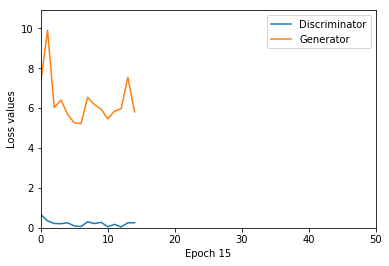

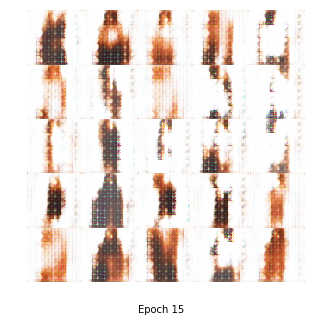

Epoch [16/50], Step [1/63], D_loss: 0.0980, G_loss: 4.3364
Epoch [16/50], Step [2/63], D_loss: 0.1055, G_loss: 4.5538
Epoch [16/50], Step [3/63], D_loss: 0.0862, G_loss: 4.7823
Epoch [16/50], Step [4/63], D_loss: 0.0886, G_loss: 4.3451
Epoch [16/50], Step [5/63], D_loss: 0.0930, G_loss: 4.4281
Epoch [16/50], Step [6/63], D_loss: 0.0990, G_loss: 4.6430
Epoch [16/50], Step [7/63], D_loss: 0.0999, G_loss: 4.0920
Epoch [16/50], Step [8/63], D_loss: 0.0921, G_loss: 4.8737
Epoch [16/50], Step [9/63], D_loss: 0.0931, G_loss: 4.4996
Epoch [16/50], Step [10/63], D_loss: 0.0888, G_loss: 4.5512
Epoch [16/50], Step [11/63], D_loss: 0.1003, G_loss: 4.4825
Epoch [16/50], Step [12/63], D_loss: 0.1049, G_loss: 4.8715
Epoch [16/50], Step [13/63], D_loss: 0.1053, G_loss: 4.0373
Epoch [16/50], Step [14/63], D_loss: 0.0992, G_loss: 6.1988
Epoch [16/50], Step [15/63], D_loss: 0.1476, G_loss: 3.4267
Epoch [16/50], Step [16/63], D_loss: 0.1602, G_loss: 8.0599
Epoch [16/50], Step [17/63], D_loss: 0.1869, G_lo

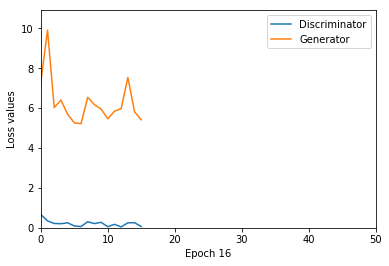

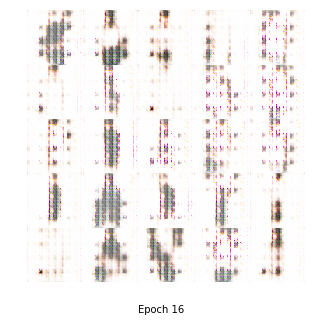

Epoch [17/50], Step [1/63], D_loss: 0.0485, G_loss: 5.7988
Epoch [17/50], Step [2/63], D_loss: 0.0549, G_loss: 5.4429
Epoch [17/50], Step [3/63], D_loss: 0.0580, G_loss: 5.8905
Epoch [17/50], Step [4/63], D_loss: 0.0489, G_loss: 5.5994
Epoch [17/50], Step [5/63], D_loss: 0.0556, G_loss: 5.4541
Epoch [17/50], Step [6/63], D_loss: 0.0596, G_loss: 5.7779
Epoch [17/50], Step [7/63], D_loss: 0.0519, G_loss: 5.6946
Epoch [17/50], Step [8/63], D_loss: 0.0516, G_loss: 5.5334
Epoch [17/50], Step [9/63], D_loss: 0.0508, G_loss: 5.8116
Epoch [17/50], Step [10/63], D_loss: 0.0539, G_loss: 5.6657
Epoch [17/50], Step [11/63], D_loss: 0.0532, G_loss: 5.9243
Epoch [17/50], Step [12/63], D_loss: 0.0355, G_loss: 5.8234
Epoch [17/50], Step [13/63], D_loss: 0.0425, G_loss: 5.4821
Epoch [17/50], Step [14/63], D_loss: 0.0420, G_loss: 5.4578
Epoch [17/50], Step [15/63], D_loss: 0.0518, G_loss: 5.8201
Epoch [17/50], Step [16/63], D_loss: 0.0447, G_loss: 5.7789
Epoch [17/50], Step [17/63], D_loss: 0.0390, G_lo

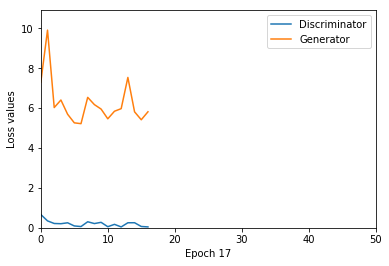

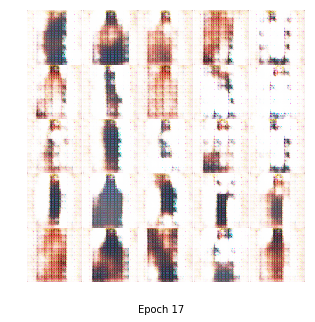

Epoch [18/50], Step [1/63], D_loss: 0.0577, G_loss: 6.2886
Epoch [18/50], Step [2/63], D_loss: 0.0596, G_loss: 6.1810
Epoch [18/50], Step [3/63], D_loss: 0.0499, G_loss: 6.0989
Epoch [18/50], Step [4/63], D_loss: 0.0679, G_loss: 5.3658
Epoch [18/50], Step [5/63], D_loss: 0.0816, G_loss: 7.8204
Epoch [18/50], Step [6/63], D_loss: 0.1013, G_loss: 2.4958
Epoch [18/50], Step [7/63], D_loss: 0.5298, G_loss: 24.3742
Epoch [18/50], Step [8/63], D_loss: 13.2232, G_loss: 3.7962
Epoch [18/50], Step [9/63], D_loss: 0.1192, G_loss: 0.9617
Epoch [18/50], Step [10/63], D_loss: 1.1009, G_loss: 17.3169
Epoch [18/50], Step [11/63], D_loss: 0.0482, G_loss: 21.4518
Epoch [18/50], Step [12/63], D_loss: 0.7530, G_loss: 19.0096
Epoch [18/50], Step [13/63], D_loss: 0.0108, G_loss: 17.1553
Epoch [18/50], Step [14/63], D_loss: 0.0005, G_loss: 15.2444
Epoch [18/50], Step [15/63], D_loss: 0.0002, G_loss: 13.8668
Epoch [18/50], Step [16/63], D_loss: 0.0005, G_loss: 12.0807
Epoch [18/50], Step [17/63], D_loss: 0.0

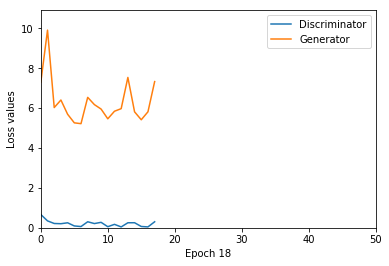

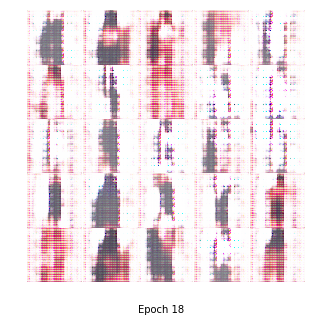

Epoch [19/50], Step [1/63], D_loss: 0.0437, G_loss: 5.4140
Epoch [19/50], Step [2/63], D_loss: 0.0470, G_loss: 5.1848
Epoch [19/50], Step [3/63], D_loss: 0.0413, G_loss: 5.2934
Epoch [19/50], Step [4/63], D_loss: 0.0539, G_loss: 5.1097
Epoch [19/50], Step [5/63], D_loss: 0.0527, G_loss: 5.2417
Epoch [19/50], Step [6/63], D_loss: 0.0529, G_loss: 5.5122
Epoch [19/50], Step [7/63], D_loss: 0.0449, G_loss: 5.5918
Epoch [19/50], Step [8/63], D_loss: 0.0477, G_loss: 5.2582
Epoch [19/50], Step [9/63], D_loss: 0.0429, G_loss: 5.2919
Epoch [19/50], Step [10/63], D_loss: 0.0493, G_loss: 5.4936
Epoch [19/50], Step [11/63], D_loss: 0.0504, G_loss: 5.4611
Epoch [19/50], Step [12/63], D_loss: 0.0520, G_loss: 5.4107
Epoch [19/50], Step [13/63], D_loss: 0.0526, G_loss: 5.3188
Epoch [19/50], Step [14/63], D_loss: 0.0492, G_loss: 5.3904
Epoch [19/50], Step [15/63], D_loss: 0.0629, G_loss: 4.9831
Epoch [19/50], Step [16/63], D_loss: 0.0666, G_loss: 5.5261
Epoch [19/50], Step [17/63], D_loss: 0.0455, G_lo

In [ ]:
# Models
G = Generator(G_input_dim, num_filters, G_output_dim)
D = Discriminator(D_input_dim, num_filters[::-1], D_output_dim)
# G.cuda()
# D.cuda()

# Loss function
criterion = nn.BCELoss()
#criterion = F.binary_cross_entropy

# Optimizers
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate_G, betas=betas_G)
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate_D, betas=betas_D)

# Training GAN
D_avg_losses = []
G_avg_losses = []

# Fixed noise for test
num_test_samples = 5*5
fixed_noise = torch.randn(num_test_samples, G_input_dim, device = device).view(-1, G_input_dim, 1, 1)

D.to(device)
G.to(device)
if use_cuda:
    torch.backends.cudnn.benchmark = True   
    
for epoch in range(num_epochs):
    D_losses = []
    G_losses = []

    
    for i, (images, _) in enumerate(data_loader):

        # image data
        mini_batch = images.size()[0]
        #x_ = Variable(images.cuda())
        x_ = images
               
        # labels
        #y_real_ = Variable(torch.ones(mini_batch).cuda())
        #y_fake_ = Variable(torch.zeros(mini_batch).cuda())
        y_real_ = torch.ones(mini_batch, requires_grad = False, device = device)
        y_fake_ = torch.zeros(mini_batch, requires_grad = False, device = device)
        
        if use_cuda:
            x_=x_.cuda() 
            
        # Train discriminator with real data
        D_real_decision = D(x_).squeeze()
        # print(D_real_decision, y_real_)
        D_real_loss = criterion(D_real_decision, y_real_)

        # Train discriminator with fake data
        z_ = torch.randn(mini_batch, G_input_dim, device = device)
        z_ = z_.view(-1, G_input_dim, 1, 1)
        
        gen_image = G(z_)

        D_fake_decision = D(gen_image).squeeze()
        D_fake_loss = criterion(D_fake_decision, y_fake_)

        # Back propagation
        D_loss = D_real_loss + D_fake_loss
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Train generator
        z_ = torch.randn(mini_batch, G_input_dim, device = device)
        z_ = z_.view(-1, G_input_dim, 1, 1)
        gen_image = G(z_)

        D_fake_decision = D(gen_image).squeeze()
        G_loss = criterion(D_fake_decision, y_real_)

        # Back propagation
        D.zero_grad()
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # loss values
        D_losses.append(D_loss.data[0])
        G_losses.append(G_loss.data[0])

        print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
              % (epoch+1, num_epochs, i+1, len(data_loader), D_loss.data[0], G_loss.data[0]))
        

    D_avg_loss = torch.mean(torch.FloatTensor(D_losses))
    G_avg_loss = torch.mean(torch.FloatTensor(G_losses))

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    plot_loss(D_avg_losses, G_avg_losses, epoch, save=True, show=True)

    # Show result for fixed noise
    plot_result(G, fixed_noise, epoch, save=True, fig_size=(5, 5), show = True)
